# Implementation of the LR Range test

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from lrfinder import LRFinder

In [2]:
%config InlineBackend.figure_format = 'retina'

## Load Dataset

In [3]:
BATCH = 32

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(buffer_size=len(train_images))
train_ds = train_ds.batch(BATCH)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)


test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.batch(BATCH)
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)

## Create a Model

In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

## Find Learning Rate

Explore learning rate from `start_lr` to `end_lr` over five `epochs`.

In [8]:
STEPS_PER_EPOCH = np.ceil(len(train_images) / BATCH)

In [9]:
lr_finder = LRFinder(model)
lr_finder.find(train_ds, start_lr=1e-6, end_lr=1, epochs=5,
               steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 2.0306 - accuracy: 0.3126
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.8091 - accuracy: 0.7521
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4977 - accuracy: 0.8263
Epoch 4/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6878 - accuracy: 0.7690
Epoch 5/5
1875/1875 [==============================] - 3s 1ms/step - loss: 2.0223 - accuracy: 0.2383


Plot the loss curve and smooth it out with Simple Moving Average. The best learning rate is a value that is approximately in the middle of the sharpest downward slope.

In [10]:
import matplotlib.pyplot as plt

def plot_loss(n_skip_beginning=10, n_skip_end=5, x_scale='log'):
    """
    Plots the loss.
    Parameters:
        n_skip_beginning - number of batches to skip on the left.
        n_skip_end - number of batches to skip on the right.
        """
    learning_rates = lr_finder.get_learning_rates()
    losses = lr_finder.get_losses()

    f, ax = plt.subplots()
    ax.set_ylabel("loss")
    ax.set_xlabel("learning rate (log scale)")
    ax.plot(learning_rates[n_skip_beginning:-n_skip_end],
            losses[n_skip_beginning:-n_skip_end])
    ax.set_xscale(x_scale)
    return(ax)

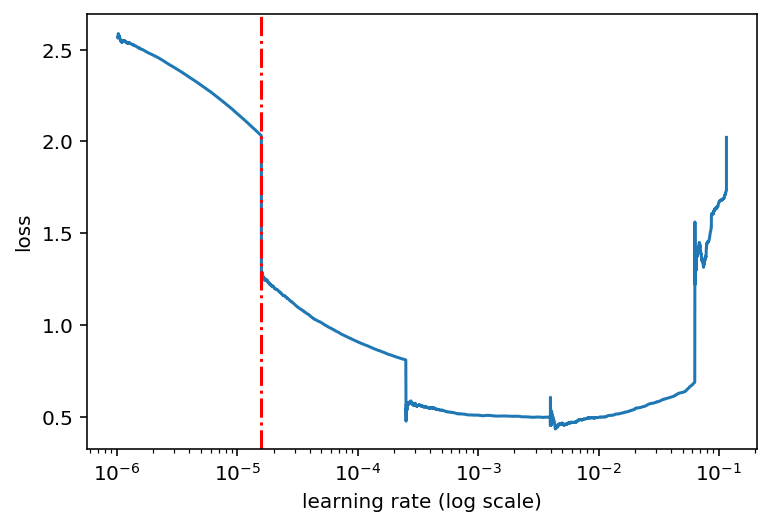

In [11]:
axs = plot_loss()
axs.axvline(x=lr_finder.get_best_lr(sma=20), c='r', linestyle='-.')